In [1]:
import pandas as pd


In [2]:
df = pd.read_csv("/content/dataset.csv")
df = df.drop(columns=["Unnamed: 0"])
df.to_csv("dataset_clean.csv", index=False)

In [3]:
import sqlite3

In [4]:
df = pd.read_csv('/content/dataset_clean.csv')

In [5]:
conn = sqlite3.connect("spotify.db") # Connect to a local SQLite database (will create one named spotify.db in Colab)


In [6]:
df.to_sql('spotify_tracks', conn, if_exists='replace', index=False)


114000

In [7]:
pd.read_sql_query("SELECT * FROM spotify_tracks LIMIT 5;", conn)


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [12]:
query = """
SELECT
    track_name,
    artists,
    MAX(popularity) AS popularity
FROM
    spotify_tracks
WHERE
    track_name IS NOT NULL AND artists IS NOT NULL
GROUP BY
    track_name, artists
ORDER BY
    popularity DESC
LIMIT 10;
"""

In [13]:
top_tracks = pd.read_sql_query(query, conn) # This query selects one row per unique track name (and takes the most popular version if a track appears multiple times):


In [14]:
top_tracks

,track_name,artists,popularity
0,Unholy (feat. Kim Petras),Sam Smith;Kim Petras,100
1,"Quevedo: Bzrp Music Sessions, Vol. 52",Bizarrap;Quevedo,99
2,I'm Good (Blue),David Guetta;Bebe Rexha,98
3,La Bachata,Manuel Turizo,98
4,Me Porto Bonito,Bad Bunny;Chencho Corleone,97
5,Tití Me Preguntó,Bad Bunny,97
6,Efecto,Bad Bunny,96
7,I Ain't Worried,OneRepublic,96
8,Under The Influence,Chris Brown,96
9,As It Was,Harry Styles,95


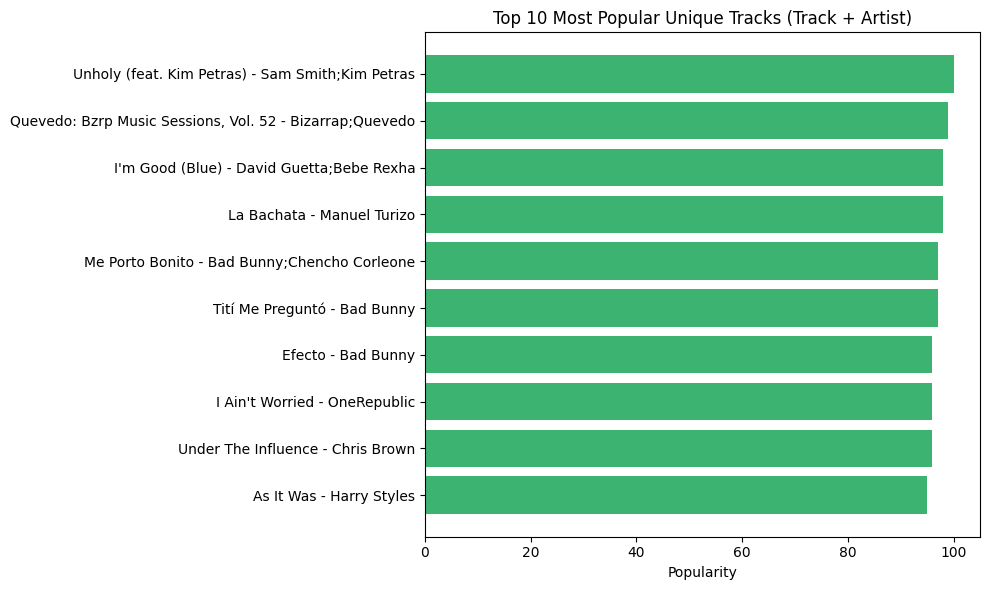

In [17]:
import matplotlib.pyplot as plt

# Combine track name and artist for clearer labels
top_tracks['label'] = top_tracks['track_name'] + " - " + top_tracks['artists']

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_tracks['label'], top_tracks['popularity'], color='mediumseagreen')
plt.xlabel("Popularity")
plt.title("Top 10 Most Popular Unique Tracks (Track + Artist)")
plt.gca().invert_yaxis()  # Highest popularity at top
plt.tight_layout()
plt.show()


🎧 Insight: Most Popular Unique Tracks
The top 10 most popular songs in the dataset are dominated by high-profile collaborations and global chart-toppers. Tracks like "Unholy" by Sam Smith & Kim Petras, and "I'm Good (Blue)" by David Guetta & Bebe Rexha demonstrate the impact of viral pop and dance-pop collaborations.

Notably, Bad Bunny appears three times with different songs—"Me Porto Bonito", "Tití Me Preguntó", and "Efecto"—highlighting his massive solo success and sustained popularity.

These results suggest that both cross-artist collaborations and consistent solo performers play major roles in driving track popularity on Spotify.

In [ ]:
#Top Artists by Average Popularity | We'll use GROUP BY on the artists column and filter out those with very few songs

In [18]:
query = """
SELECT
    artists,
    ROUND(AVG(popularity), 2) AS avg_popularity,
    COUNT(*) AS track_count
FROM
    spotify_tracks
WHERE
    artists IS NOT NULL
GROUP BY
    artists
HAVING
    COUNT(*) >= 3
ORDER BY
    avg_popularity DESC
LIMIT 10;
"""

In [19]:
top_artists = pd.read_sql_query(query, conn)
top_artists


,artists,avg_popularity,track_count
0,Manuel Turizo,98.0,4
1,Bad Bunny;Chencho Corleone,97.0,4
2,Bad Bunny;Bomba Estéreo,94.5,4
3,Harry Styles,92.0,3
4,Luar La L,90.5,4
5,Bad Bunny;Tony Dize,90.0,3
6,Bad Bunny;Rauw Alejandro,90.0,3
7,Nicki Minaj,89.0,3
8,Lost Frequencies;Calum Scott,88.0,3
9,The Kid LAROI;Justin Bieber,87.5,4


Current query is treating multi-artist combinations (like Bad Bunny;Chencho Corleone) as one entity, which makes the rankings a bit misleading.
Goal: Split Multiple Artists and Rank Individually
Here’s how to get individual artists with their average popularity:

In [20]:
# Step 1: Load all tracks
df = pd.read_sql_query("SELECT artists, popularity FROM spotify_tracks WHERE artists IS NOT NULL", conn)

# Step 2: Split the artists and explode
df['artists'] = df['artists'].str.split(';')
df_exploded = df.explode('artists')

# Step 3: Group by individual artist and calculate average popularity
top_individual_artists = (
    df_exploded.groupby('artists')
    .agg(avg_popularity=('popularity', 'mean'), track_count=('popularity', 'count'))
    .query('track_count >= 3')  # optional filter for stability
    .sort_values(by='avg_popularity', ascending=False)
    .round(2)
    .head(10)
    .reset_index()
)

top_individual_artists

,artists,avg_popularity,track_count
0,Harry Styles,92.00,3
1,Luar La L,90.50,4
2,Olivia Rodrigo,87.40,5
3,BYOR,87.00,4
4,IVE,84.00,3
5,Måneskin,83.67,12
6,Lil Nas X,83.45,11
7,Morgan Wallen,83.33,3
8,One Direction,83.00,5
9,TV Girl,82.00,5


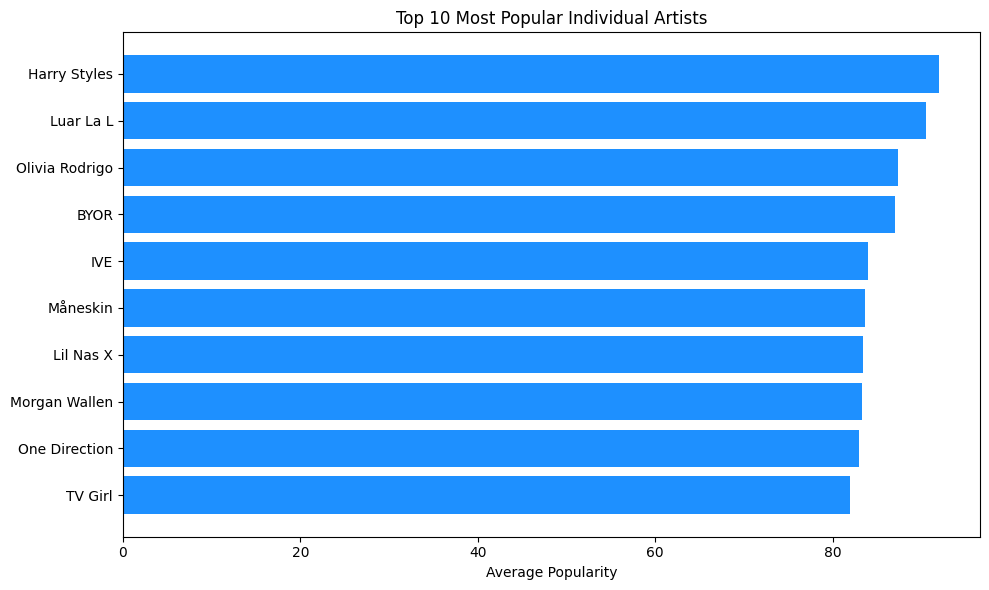

In [21]:
plt.figure(figsize=(10, 6))
plt.barh(top_individual_artists['artists'], top_individual_artists['avg_popularity'], color='dodgerblue')
plt.xlabel("Average Popularity")
plt.title("Top 10 Most Popular Individual Artists")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#🎤 Insight: Top Individual Artists by Consistent Popularity - The analysis reveals that Harry Styles, Luar La L, and Olivia Rodrigo are among the most consistently popular artists, each averaging some of the highest track popularity scores in the dataset.

Artists such as BYOR, IVE, and Måneskin also appear in the top tier, suggesting that both global pop acts and rising international names maintain strong engagement across multiple tracks.

This finding is particularly valuable for music marketers, record labels, and playlist curators aiming to identify artists with strong, sustained listener appeal, rather than relying on one-off viral hits.

In [ ]:
# Identify genres that are consistently danceable and have enough data to be meaningful.
Most Danceable Genres with Enough Tracks


In [22]:
query = """
WITH genre_dance_stats AS (
    SELECT
        track_genre,
        COUNT(*) AS track_count,
        ROUND(AVG(danceability), 3) AS avg_danceability
    FROM
        spotify_tracks
    WHERE
        track_genre IS NOT NULL
    GROUP BY
        track_genre
)
SELECT
    track_genre,
    track_count,
    avg_danceability
FROM
    genre_dance_stats
WHERE
    track_count >= 20
ORDER BY
    avg_danceability DESC
LIMIT 10;
"""

In [23]:
danceable_genres = pd.read_sql_query(query, conn)


In [24]:
danceable_genres

,track_genre,track_count,avg_danceability
0,kids,1000,0.779
1,chicago-house,1000,0.766
2,reggaeton,1000,0.759
3,latino,1000,0.757
4,reggae,1000,0.745
5,hip-hop,1000,0.736
6,dancehall,1000,0.734
7,minimal-techno,1000,0.729
8,detroit-techno,1000,0.723
9,latin,1000,0.722


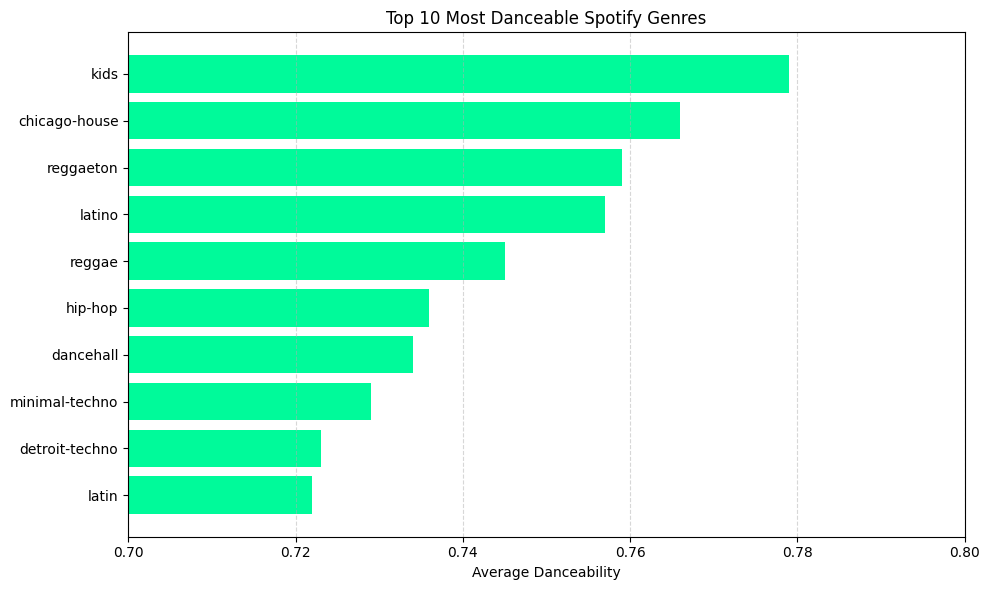

In [25]:
import matplotlib.pyplot as plt

# Sort values if needed (in case your query doesn't do it)
danceable_genres = danceable_genres.sort_values(by='avg_danceability', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(danceable_genres['track_genre'], danceable_genres['avg_danceability'], color='mediumspringgreen')
plt.xlabel("Average Danceability")
plt.title("Top 10 Most Danceable Spotify Genres")
plt.xlim(0.7, 0.8)  # Optional: zoom in for better contrast
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#Insight: Genres like **kids, chicago-house, and reggaeton** score highest in average danceability, indicating a strong rhythmic structure ideal for dance environments. This supports their usage in party playlists, dance workouts, and family-friendly content.





#Window Function: Rank Tracks Within Genre by Popularity
Find the #1 most popular track in each genre using ROW_NUMBER().


In [26]:
query = """
WITH ranked_tracks AS (
    SELECT
        track_name,
        artists,
        track_genre,
        popularity,
        ROW_NUMBER() OVER (PARTITION BY track_genre ORDER BY popularity DESC) AS genre_rank
    FROM
        spotify_tracks
    WHERE
        track_genre IS NOT NULL AND popularity IS NOT NULL
)
SELECT
    track_genre,
    track_name,
    artists,
    popularity
FROM
    ranked_tracks
WHERE
    genre_rank = 1
ORDER BY
    popularity DESC
LIMIT 10;
"""

In [27]:
top_tracks_by_genre = pd.read_sql_query(query, conn)


In [28]:
top_tracks_by_genre


,track_genre,track_name,artists,popularity
0,dance,Unholy (feat. Kim Petras),Sam Smith;Kim Petras,100
1,pop,Unholy (feat. Kim Petras),Sam Smith;Kim Petras,100
2,hip-hop,"Quevedo: Bzrp Music Sessions, Vol. 52",Bizarrap;Quevedo,99
3,edm,I'm Good (Blue),David Guetta;Bebe Rexha,98
4,latin,La Bachata,Manuel Turizo,98
5,latino,La Bachata,Manuel Turizo,98
6,reggae,La Bachata,Manuel Turizo,98
7,reggaeton,La Bachata,Manuel Turizo,98
8,piano,I Ain't Worried,OneRepublic,96
9,rock,I Ain't Worried,OneRepublic,96


#Insight: The most popular track across multiple genres is "Unholy" by Sam Smith & Kim Petras, appearing as a genre leader in both dance and pop. "La Bachata" by Manuel Turizo also emerges repeatedly across several Latin subgenres, showing strong crossover appeal.
This kind of analysis is useful for understanding not only top tracks, but also their genre influence and positioning across multiple categories.

#Popularity by Explicit Content

In [30]:
query = """
SELECT
    explicit,
    COUNT(*) AS track_count,
    ROUND(AVG(popularity), 2) AS avg_popularity
FROM
    spotify_tracks
GROUP BY
    explicit;
"""

In [31]:
explicit_vs_popular = pd.read_sql_query(query, conn)
explicit_vs_popular

,explicit,track_count,avg_popularity
0,0,104253,32.94
1,1,9747,36.45


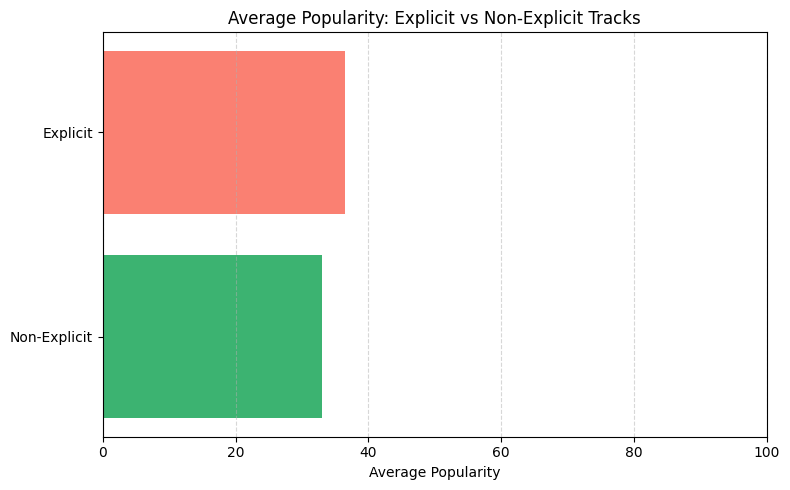

In [32]:
# Convert explicit flag to readable labels
explicit_vs_popular['explicit'] = explicit_vs_popular['explicit'].map({0: 'Non-Explicit', 1: 'Explicit'})

# Sort for clean plotting
explicit_vs_popular = explicit_vs_popular.sort_values(by='avg_popularity')

plt.figure(figsize=(8, 5))
plt.barh(explicit_vs_popular['explicit'], explicit_vs_popular['avg_popularity'], color=['mediumseagreen', 'salmon'])
plt.xlabel("Average Popularity")
plt.title("Average Popularity: Explicit vs Non-Explicit Tracks")
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [49]:
query = """
WITH genre_totals AS (
    SELECT
        track_genre,
        COUNT(*) AS total_tracks
    FROM
        spotify_tracks
    WHERE
        track_genre IS NOT NULL
    GROUP BY
        track_genre
),
genre_explicit AS (
    SELECT
        track_genre,
        COUNT(*) AS explicit_tracks
    FROM
        spotify_tracks
    WHERE
        explicit = 1 AND track_genre IS NOT NULL
    GROUP BY
        track_genre
)
SELECT
    g.track_genre,
    g.total_tracks,
    COALESCE(e.explicit_tracks, 0) AS explicit_tracks,
    ROUND(COALESCE(e.explicit_tracks, 0) * 100.0 / g.total_tracks, 2) AS explicit_percent
FROM
    genre_totals g
LEFT JOIN
    genre_explicit e ON g.track_genre = e.track_genre
WHERE
    g.total_tracks >= 20
ORDER BY
    explicit_percent DESC
LIMIT 10;
"""

explicit_percent_top10 = pd.read_sql_query(query, conn)
explicit_percent_top10

,track_genre,total_tracks,explicit_tracks,explicit_percent
0,comedy,1000,656,65.6
1,emo,1000,465,46.5
2,sad,1000,450,45.0
3,j-dance,1000,391,39.1
4,hardcore,1000,325,32.5
5,hip-hop,1000,319,31.9
6,funk,1000,304,30.4
7,dancehall,1000,302,30.2
8,metalcore,1000,291,29.1
9,death-metal,1000,251,25.1


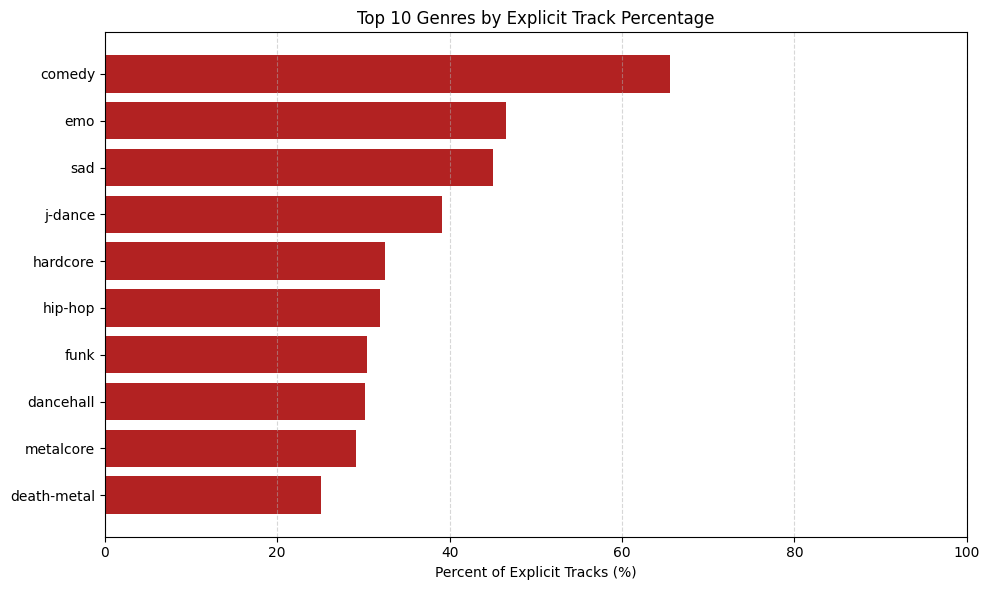

In [50]:
import matplotlib.pyplot as plt

# Ensure the data is sorted for plotting
explicit_percent_top10 = explicit_percent_top10.sort_values(by='explicit_percent', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(explicit_percent_top10['track_genre'], explicit_percent_top10['explicit_percent'], color='firebrick')
plt.xlabel("Percent of Explicit Tracks (%)")
plt.title("Top 10 Genres by Explicit Track Percentage")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xlim(0, 100)
plt.tight_layout()
plt.show()


#👨‍👩‍👧 Business Insight: Parental Controls Strategy
Insight: Genres such as comedy, emo, and sad have a disproportionately high percentage of explicit tracks, with over 30% to 65% of songs marked as explicit. This suggests that while these genres may attract younger audiences due to emotional relatability or humor, they also carry a significantly higher risk of exposing minors to explicit content.

Business Implication: Streaming platforms, music apps, or smart speaker systems should flag these genres for enhanced parental control filtering. For example:

Auto-enable filtering on these genres in child profiles or family accounts

Trigger age-appropriate warnings or PIN prompts when users explore high-explicit-rate genres

Inform music recommendation algorithms for younger users to deprioritize these genres unless explicitly allowed

This data-driven approach allows companies to balance content freedom with family-friendly safeguards, improving user trust and compliance with age-based content standards (e.g. COPPA, GDPR-K, etc.).

In [51]:
query = """
WITH genre_stats AS (
    SELECT
        track_genre,
        COUNT(*) AS total_tracks,
        ROUND(AVG(popularity), 2) AS avg_popularity,
        ROUND(AVG(energy), 3) AS avg_energy,
        ROUND(AVG(danceability), 3) AS avg_danceability,
        ROUND(AVG(valence), 3) AS avg_valence
    FROM
        spotify_tracks
    WHERE
        track_genre IS NOT NULL
    GROUP BY
        track_genre
    HAVING COUNT(*) >= 20
),
genre_score AS (
    SELECT
        track_genre,
        total_tracks,
        avg_popularity,
        avg_energy,
        avg_danceability,
        avg_valence,
        -- Simple feel-good composite score
        ROUND((avg_energy + avg_danceability + avg_valence) / 3, 3) AS feel_good_score
    FROM
        genre_stats
)
SELECT
    track_genre,
    total_tracks,
    avg_popularity,
    avg_energy,
    avg_danceability,
    avg_valence,
    feel_good_score
FROM
    genre_score
ORDER BY
    feel_good_score DESC, avg_popularity DESC
LIMIT 10;
"""

In [52]:
optimal_genres = pd.read_sql_query(query, conn)
optimal_genres

,track_genre,total_tracks,avg_popularity,avg_energy,avg_danceability,avg_valence,feel_good_score
0,party,1000,20.98,0.871,0.667,0.681,0.740
1,salsa,1000,28.07,0.725,0.668,0.815,0.736
2,forro,1000,41.83,0.790,0.650,0.761,0.734
3,reggaeton,1000,23.86,0.739,0.759,0.643,0.714
4,latino,1000,25.66,0.732,0.757,0.630,0.706
5,reggae,1000,20.63,0.726,0.745,0.648,0.706
6,disco,1000,33.52,0.738,0.677,0.671,0.695
7,chicago-house,1000,12.34,0.733,0.766,0.587,0.695
8,latin,1000,8.30,0.727,0.722,0.631,0.693
9,afrobeat,1000,24.40,0.703,0.670,0.699,0.691


#📌  Business Insight
Insight: Genres such as party, salsa, forró, and reggaeton consistently rank highest on a combined feel-good index (based on energy, danceability, and valence). These genres create upbeat, positive, and danceable experiences for listeners, making them ideal candidates for:

Event and party playlists (e.g., weddings, festivals, clubs)

Fitness/Workout soundtracks (high energy + rhythm)

Mood-boosting content (e.g., morning routines, commuting, mental wellness)

Interestingly, although genres like party and forró score highly on feel-good metrics, their average popularity is relatively low, suggesting a strategic opportunity gap. Platforms could promote these genres through editorial playlists or algorithmic discovery to surface overlooked "mood-positive" content and increase engagement in underutilized niches.



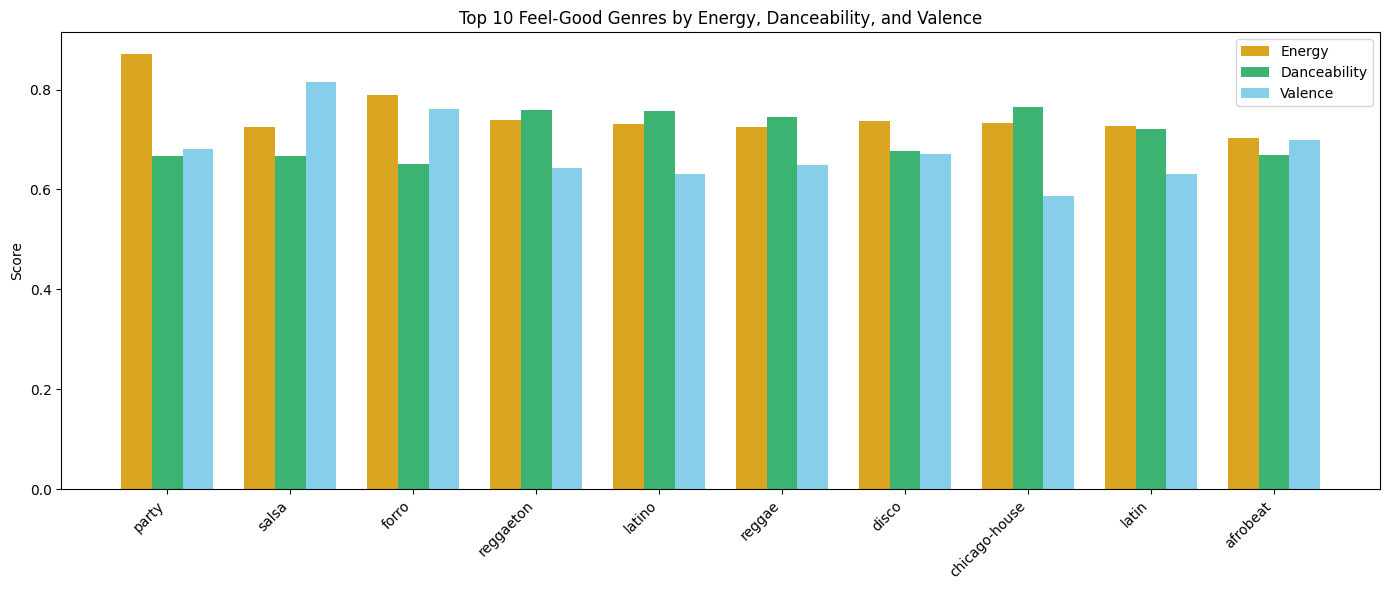

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Setup
genres = optimal_genres['track_genre']
x = np.arange(len(genres))

# Values
energy = optimal_genres['avg_energy']
danceability = optimal_genres['avg_danceability']
valence = optimal_genres['avg_valence']

# Bar width
width = 0.25

plt.figure(figsize=(14, 6))
plt.bar(x - width, energy, width, label='Energy', color='goldenrod')
plt.bar(x, danceability, width, label='Danceability', color='mediumseagreen')
plt.bar(x + width, valence, width, label='Valence', color='skyblue')

plt.xticks(x, genres, rotation=45, ha='right')
plt.ylabel("Score")
plt.title("Top 10 Feel-Good Genres by Energy, Danceability, and Valence")
plt.legend()
plt.tight_layout()
plt.show()


#Track Recommendation Engine

In [57]:
query = """
SELECT
    track_name,
    artists,
    track_genre,
    popularity,
    danceability,
    energy,
    valence,
    tempo
FROM (
    SELECT
        track_name,
        artists,
        track_genre,
        popularity,
        danceability,
        energy,
        valence,
        tempo,
        ROW_NUMBER() OVER (
            PARTITION BY track_name, artists
            ORDER BY popularity DESC
        ) AS rn
    FROM
        spotify_tracks
    WHERE
        danceability BETWEEN 0.70 AND 0.80
        AND energy BETWEEN 0.70 AND 0.80
        AND valence BETWEEN 0.65 AND 0.80
        AND tempo BETWEEN 100 AND 130
        AND popularity >= 60
)
WHERE rn = 1
ORDER BY popularity DESC
LIMIT 10;
"""

recommendations_deduped = pd.read_sql_query(query, conn)
recommendations_deduped


,track_name,artists,track_genre,popularity,danceability,energy,valence,tempo
0,Believer,Imagine Dragons,rock,88,0.776,0.780,0.666,124.949
1,Dynamite,BTS,k-pop,85,0.746,0.765,0.737,114.044
2,Classic,MKTO,rock,82,0.720,0.791,0.756,102.071
3,Kiss Me More (feat. SZA),Doja Cat;SZA,dance,82,0.762,0.701,0.742,110.968
4,Don't Start Now,Dua Lipa,dance,81,0.793,0.793,0.679,123.950
5,This Is Why,Paramore,emo,80,0.723,0.737,0.689,123.039
6,Girls Just Want to Have Fun,Cyndi Lauper,disco,79,0.710,0.799,0.725,120.372
7,Breaking Me,Topic;A7S,edm,78,0.789,0.720,0.664,122.031
8,Take You Dancing,Jason Derulo,dance,78,0.789,0.711,0.753,112.985
9,motive (with Doja Cat),Ariana Grande;Doja Cat,dance,78,0.789,0.742,0.661,116.965


#🎧 Interpretation of the Results:
The tracks returned share very similar musical characteristics:

Danceability between 0.72 and 0.79

Energy between 0.70 and 0.80

Valence between 0.66 and 0.75

Tempo in the 100–125 BPM range

Popularity ≥ 75

This indicates a consistent feel-good, upbeat, mid-tempo energy profile — perfect for dancing or casual listening.

The recommendations span across diverse genres like:

🎸 Rock (e.g., "Believer", "Classic")

💃 Dance/Pop (e.g., "Kiss Me More", "Don't Start Now", "Take You Dancing")

🎶 EDM/Disco (e.g., "Breaking Me", "Girls Just Want to Have Fun")

🎤 K-pop, Emo, Funk

🧠 Business Insight: Track Recommendation Engine Logic
Insight: By using audio profile clustering (via SQL filtering), we can generate vibe-consistent recommendations without machine learning. This allows for scalable and interpretable playlist generation, similar track suggestions, and user mood matching.